#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 학습을 위한 전처리 : 자연어 처리를 위한 전처리를 수행합니다.
        * 형태소 분석기를 활용하여 문장 어절들에 대해 형태소로 변환합니다.
    * 전처리 결과를 저장합니다. 

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 로컬 / 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 챗봇 데이터.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:\Users\<ID> 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글코랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/aivle/6차 미니프로젝트/'

### 3) 데이터 읽어오기

In [4]:
common_path = os.path.join(path, '일상대화.xlsx')
faq_path = os.path.join(path, '챗봇데이터.xlsx')

In [5]:
# 일상대화
common_df = pd.read_excel(common_path)

# 에이블스쿨 질문답변
faq_df = pd.read_excel(faq_path)


* 데이터 둘러보기

In [6]:
common_df.head(3)

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.


In [7]:
faq_df.head(3)

,intent,Q,A
0,0,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
1,0,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
2,0,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...


## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경, 
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [8]:
# common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경
common_df.rename(columns = {'질문':'Q', '답변':'A'}, inplace = True)

#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* intent 번호 조정

In [9]:
np.unique(common_df['intent'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [10]:
faq_df['intent'] = faq_df['intent'] + 31

* 데이터셋 통합(pd.concat)

In [11]:
data = pd.concat([common_df, faq_df], ignore_index = True, axis = 0)

In [12]:
data.head(3)

,intent,Q,A
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.


#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

In [13]:
data['type'] = np.where(data['intent'] <= 30, 0, 1)

### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

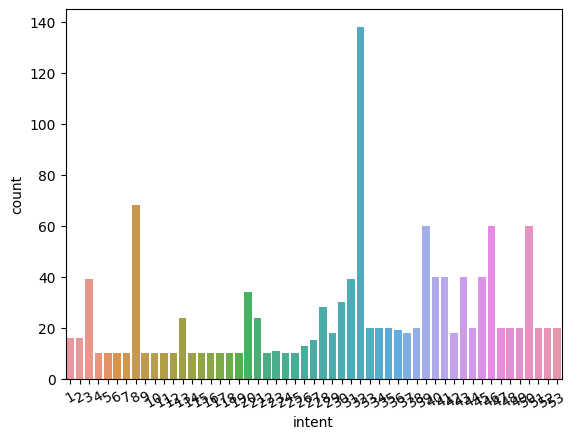

In [16]:
sns.countplot(x = 'intent', data = data)
plt.xticks(rotation = 30)
plt.show()

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [ ]:
temp = data[['Q', 'type']].copy()
temp['len'] = temp['Q'].apply(len)
 
# 기초 통계량 : 일상 대화
display(temp.loc[temp['type'] == 0, ['len']].describe().T)
# 기초 통계량 : Q&A
display(temp.loc[temp['type'] == 1, ['len']].describe().T)

,count,mean,std,min,25%,50%,75%,max
len,506.0,10.126482,3.971658,3.0,7.0,10.0,12.0,28.0


,count,mean,std,min,25%,50%,75%,max
len,792.0,23.434343,10.25827,6.0,17.0,21.0,28.0,127.0


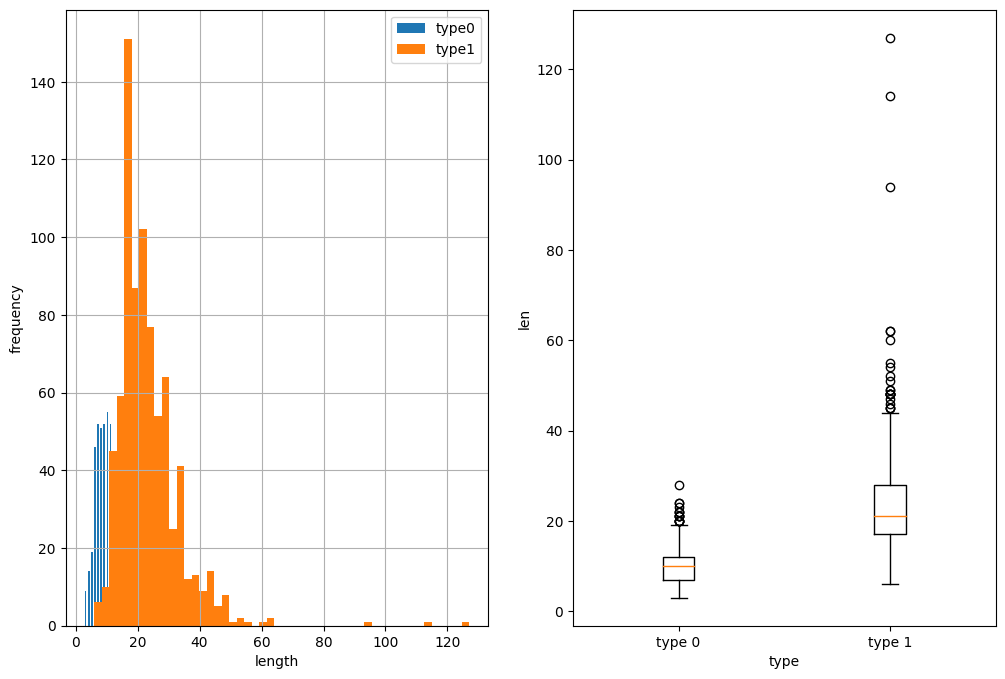

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.hist(temp[temp['type'] == 0]['len'], bins = 50, label = 'type0')
plt.hist(temp[temp['type'] == 1]['len'], bins = 50, label = 'type1')
plt.grid()
plt.legend()
plt.xlabel('length')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.boxplot([temp[temp['type'] == 0]['len'], temp[temp['type'] == 1]['len']],
            labels = ['type 0', 'type 1'])
plt.xlabel('type')
plt.ylabel('len')
plt.show()

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [ ]:
temp = data[['Q', 'type']].copy()
temp['len'] = temp['Q'].apply(len)

display(temp.loc[temp['type']==0, ['len']].describe().T)
display(temp.loc[temp['type']==1, ['len']].describe().T)

,count,mean,std,min,25%,50%,75%,max
len,506.0,10.126482,3.971658,3.0,7.0,10.0,12.0,28.0


,count,mean,std,min,25%,50%,75%,max
len,792.0,23.434343,10.25827,6.0,17.0,21.0,28.0,127.0


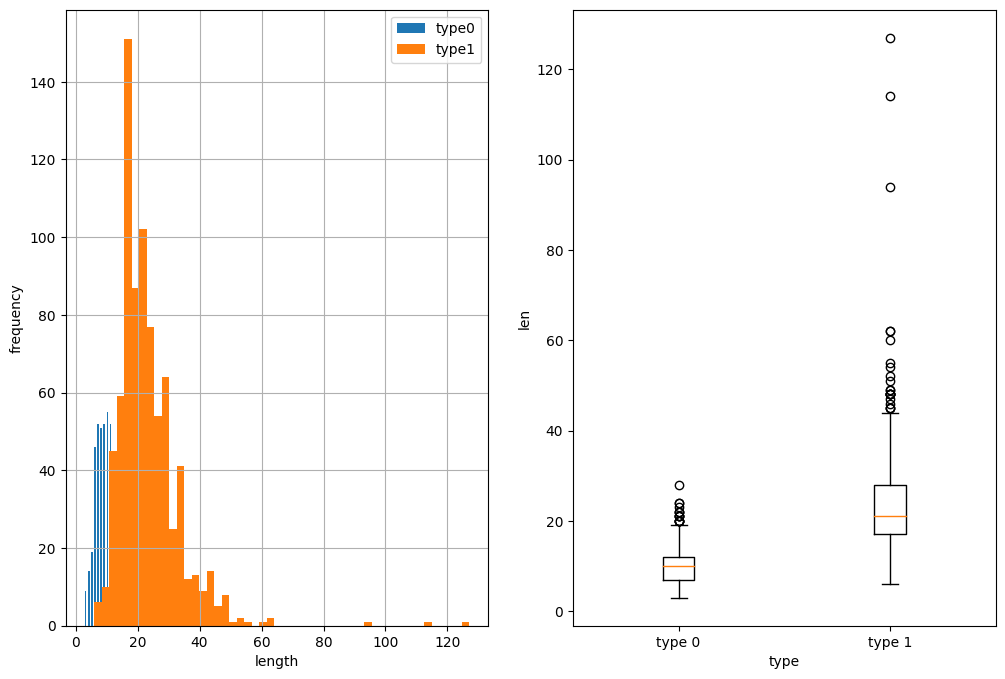

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.hist(temp[temp['type'] == 0]['len'], bins = 50, label = 'type0')
plt.hist(temp[temp['type'] == 1]['len'], bins = 50, label = 'type1')
plt.grid()
plt.legend()
plt.xlabel('length')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.boxplot([temp[temp['type'] == 0]['len'], temp[temp['type'] == 1]['len']],
            labels = ['type 0', 'type 1'])
plt.xlabel('type')
plt.ylabel('len')
plt.show()

## 3.데이터 전처리

* 세부요구사항
    * 다음 항목에 해당되는 전처리 함수를 각각 생성하여 하나로 합쳐봅시다.
        * 특수문자 제거 : 정규 표현식을 활용합니다. (띄어쓰기, \n 등)
        * 형태소 분석기 사용 : konlpy(mecab, kkma, Okt, etc), soynlp, khaiii 등 여러 형태소 분석기를 활용합니다.
    * 문장길이를 조절하여 모델 input으로 활용하기
    * joblib.dump를 이용하여 전처리 결과 데이터를 저장합니다.

### (1) 학습/평가 데이터 분리
   * test 데이터 : intent마다 무작위로 질문 2개를 뽑아 test 데이터로 분리
   * train 데이터 : 나머지 데이터


In [ ]:
test = data.groupby('intent').sample(n = 2, random_state = 20)

In [ ]:
train = data.loc[~data.index.isin(test.index)]

In [ ]:
test

,intent,Q,A,type
15,1,노트북 안돼,AS센터에 맡겨보세요.,0
1,1,액정 나갔어,as 맡기세요.,0
29,2,올해도 건강하고 행복하게 살거야,가장 중요한 목표네요.,0
20,2,아프면 안 되는데,가장 중요한 목표네요.,0
67,3,너무 추워서 죽을 것 같았어,감기 조심하세요.,0
...,...,...,...,...
1239,82,지원사항이 있나요?,"네, 취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며,...",1
1276,83,대면 교육 시 별도로 교통비나 숙박비를 지원해주나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
1262,83,"대면 교육을 받을 때, 숙소나 기숙사를 제공받을 수 있는지 여부를 알려주세요.",숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1
1280,84,이 교육과정은 다른 교육과정과 비교해서 어떤 부분에서 더 우수한가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


### (2) 형태소 분석하기
- konlpy, mecab 설치 후 형태소 분석 함수 생성
    * [코랩]아래 두 코드셀을 순차적으로 실행하면 설치 됩니다.
        * 참조 : https://konlpy.org/en/latest/install/
- 형태소 분석 결과를 다음의 이름으로 생성하시오.
    - clean_train_questions
    - clean_test_questions

#### 1) 형태소 분석 패키지 설치

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Buil

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.7 MB/s eta 0:00:00
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1247k      0  0:00:01  0:00:01 --:--:-- 3765k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1


#### 2) 형태소 분석을 위한 함수를 제공합니다.

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [ ]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

#### 3) 형태소 분석 테스트
* 몇개 데이터에 대해 형태소 분석 확인하기

In [ ]:
tokenize('komoran', '핸드폰 떨어뜨려서 고장 났나봐')

'핸드폰 떨어뜨리 어서 고장 나 았 나 보 아'

In [ ]:
for q in train['Q'].head():
    print(f'형태소 분석 전: {q}')
    print(f"형태소 분석 후(명사 only): {tokenize('mecab', q, True)}")
    print(f"형태소 분석 후(품사 전체): {tokenize('mecab', q, False)}")

형태소 분석 전: 떨어뜨려서 핸드폰 액정 나갔어
형태소 분석 후(명사 only): 핸드폰 액정
형태소 분석 후(품사 전체): 떨어뜨려서 핸드폰 액정 나갔 어
형태소 분석 전: 핸드폰 떨어뜨려서 고장 났나봐
형태소 분석 후(명사 only): 핸드폰 고장
형태소 분석 후(품사 전체): 핸드폰 떨어뜨려서 고장 났 나 봐
형태소 분석 전: 노트북이 작동이 안되네
형태소 분석 후(명사 only): 노트북 작동
형태소 분석 후(품사 전체): 노트북 이 작동 이 안 되 네
형태소 분석 전: 노트북 키보드가 안먹히네
형태소 분석 후(명사 only): 노트북 키보드
형태소 분석 후(품사 전체): 노트북 키보드 가 안 먹히 네
형태소 분석 전: 노트북 전원이 안들어와.
형태소 분석 후(명사 only): 노트북 전원
형태소 분석 후(품사 전체): 노트북 전원 이 안 들어와 .


#### 4) train, test의 Q에 대해 형태소 분석하여 저장하기
* 데이터프레임의 각 행 별로 함수를 적용하는 방법
    * .apply(lambda ..........) 를 활용하면 손쉽게 처리할수 있습니다.

In [ ]:
clean_train_questions = train['Q'].apply(lambda x: tokenize('mecab', x))
clean_test_questions = test['Q'].apply(lambda x: tokenize('mecab', x))

In [ ]:
type(clean_train_questions)

pandas.core.series.Series

### (3) 전처리 완료된 데이터를 파일로 저장하기
- 총 4개의 파일을 저장합니다.
    * train 셋
    * test 셋
    * 전처리된 데이터
        * clean_train_questions
        * clean_test_questions
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [ ]:
joblib.dump(train, os.path.join(path, 'train.csv'))
joblib.dump(test, os.path.join(path, 'test.csv'))

['/content/drive/MyDrive/aivle/6차 미니프로젝트/test.csv']

In [ ]:
joblib.dump(clean_train_questions, os.path.join(path, 'clean_train_question.csv'))
joblib.dump(clean_test_questions, os.path.join(path, 'clean_test_question.csv'))

['/content/drive/MyDrive/aivle/6차 미니프로젝트/clean_test_question.csv']